### **1. Get Data from BigQuery**

In [81]:
# GCP Libraries
from google.cloud import bigquery
from google.oauth2 import service_account

# Engineering and Visualization
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Projett credentials with account service
path = '/content/drive/MyDrive/Weather_Project/Weather Project-6fa8e059f642.json'

In [3]:
# Credentials
credentials = service_account.Credentials.from_service_account_file(path)
project_id = credentials.project_id
client = bigquery.Client(project=project_id, credentials=credentials)

In [4]:
# SQL Query that will run in BQ
query_string = """
SELECT *
FROM (SELECT *
            , ROW_NUMBER() OVER(PARTITION BY last_updated, city ORDER BY last_updated, city) AS row_num
            FROM `weather-project-305419.Daily_Weather.Weather-Info`) as row_weather
WHERE row_num = 1
"""

In [5]:
# Transform sql query results in a pandas dataframe
df = (
    client.query(query_string)
    .result()
    .to_dataframe()
)
df.head()

,last_updated_epoch,last_updated,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,city,extraction_date,row_num
0,1619248500,2021-04-24 03:15,12.2,54.0,0,Partly cloudy,10.1,16.2,266,W,1016.0,30.5,0.0,0.0,50,12,10.5,50.9,10.0,6.0,1.0,15.0,24.1,New York,None,1
1,1619509500,2021-04-27 04:45,16.8,62.2,0,Overcast,5.8,9.4,125,SE,1015.0,30.5,0.0,0.0,90,93,16.8,62.2,10.0,6.0,1.0,8.7,14.0,Carapicuiba,None,1
2,1619521200,2021-04-27 07:00,8.3,46.9,1,Overcast,0.0,0.0,0,N,1021.0,30.6,0.0,0.0,48,100,6.1,42.9,16.0,9.0,1.0,11.2,18.0,New York,None,1
3,1619681400,2021-04-29 03:30,16.1,61.0,0,Partly cloudy,0.0,0.0,256,WSW,1010.0,30.3,0.0,0.0,81,25,16.1,61.0,14.0,8.0,1.0,13.9,22.3,New York,None,1
4,1619683200,2021-04-29 05:00,14.8,58.6,0,Patchy rain possible,8.1,13.0,143,SE,1020.0,30.6,0.1,0.0,86,81,14.3,57.7,10.0,6.0,1.0,12.1,19.4,Carapicuiba,None,1


In [6]:
%cd /content/drive/MyDrive/Weather_Project

/content/drive/MyDrive/Weather_Project


In [7]:
# Saving in a pickle file so we don't need query in database again
df.to_pickle("weather_data")

### **2. Data Transformation for Analysis**

In [8]:
# Open pickle file
file = open('/content/drive/MyDrive/Weather_Project/weather_data', 'rb')
df = pickle.load(file)

In [9]:
cidades = ['Paris', 'Sao Paulo', 'Carapicuiba', 'New York', 'Otawwa', 'London', 'Rome', 'Moscow'
        , 'Hong Kong', 'Beijing']
df = df.loc[df['city'].isin(cidades)]
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.shape

(97871, 26)

In [10]:
# Drop useless columns for analysis
df = df.drop(columns=['row_num', 'last_updated_epoch', 'extraction_date'])
df = df.dropna()
# number of rows and columns
print(df.shape, df['city'].unique())

(97871, 23) ['New York' 'Carapicuiba' 'Sao Paulo' 'Paris' 'Rome' 'Hong Kong' 'Beijing'
 'Moscow' 'London']


In [11]:
# Target: Predict condition (that means wether is raining or not) 
df['condition'].unique()

array(['Partly cloudy', 'Overcast', 'Patchy rain possible', 'Sunny',
       'Light rain', 'Clear', 'Light rain shower', 'Mist', 'Cloudy',
       'Thundery outbreaks possible', 'Light drizzle', 'Light snow',
       'Moderate rain', 'Freezing fog', 'Light snow showers',
       'Patchy light snow', 'Heavy rain', 'Moderate or heavy rain shower',
       'Freezing drizzle', 'Patchy light rain with thunder',
       'Patchy light drizzle', 'Heavy snow',
       'Moderate or heavy snow showers', 'Moderate snow', 'Fog',
       'Moderate rain at times', 'Patchy light rain',
       'Torrential rain shower', 'Blizzard', 'Patchy moderate snow',
       'Light freezing rain', 'Patchy heavy snow', 'Light sleet showers',
       'Light sleet', 'Moderate or heavy sleet',
       'Moderate or heavy rain with thunder',
       'Moderate or heavy snow with thunder', 'Heavy rain at times',
       'Ice pellets'], dtype=object)

We need to resume this bunch of conditions and define our target class

In [12]:
# This conditions means that it's raining in the moment
raining_list = ['Light rain', 'Light rain shower', 'Light drizzle', 'Heavy rain', 'Moderate rain', 'Patchy light rain with thunder'
            , 'Moderate or heavy rain shower', 'Patchy light rain', 'Torrential rain shower', 'Moderate rain at times'
            , 'Moderate or heavy rain with thunder']

In [13]:
# Creating the target variable
df['target'] = df['condition'].apply(lambda x: 1 if x in raining_list else 0)
df['target'].unique()

array([0, 1])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97871 entries, 0 to 104645
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   last_updated  97871 non-null  datetime64[ns]
 1   temp_c        97871 non-null  object        
 2   temp_f        97871 non-null  object        
 3   is_day        97871 non-null  object        
 4   condition     97871 non-null  object        
 5   wind_mph      97871 non-null  object        
 6   wind_kph      97871 non-null  object        
 7   wind_degree   97871 non-null  object        
 8   wind_dir      97871 non-null  object        
 9   pressure_mb   97871 non-null  object        
 10  pressure_in   97871 non-null  object        
 11  precip_mm     97871 non-null  object        
 12  precip_in     97871 non-null  object        
 13  humidity      97871 non-null  object        
 14  cloud         97871 non-null  object        
 15  feelslike_c   97871 non-null  objec

In [15]:
# Create a list with columns to be converted
float_list = list()
for column_name in df.drop(columns='target').columns:
  if str(df[f'{column_name}'][0]).replace(".", "").replace("-", "").isnumeric() == True:
    float_list.append(column_name)

In [16]:
# function to convert columns to float
def to_float(df):
  for column in df.columns:
    if column in float_list:
      df[f'{column}'] = df[f'{column}'].astype("float")
  return df.info()

In [17]:
to_float(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97871 entries, 0 to 104645
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   last_updated  97871 non-null  datetime64[ns]
 1   temp_c        97871 non-null  float64       
 2   temp_f        97871 non-null  float64       
 3   is_day        97871 non-null  float64       
 4   condition     97871 non-null  object        
 5   wind_mph      97871 non-null  float64       
 6   wind_kph      97871 non-null  float64       
 7   wind_degree   97871 non-null  float64       
 8   wind_dir      97871 non-null  object        
 9   pressure_mb   97871 non-null  float64       
 10  pressure_in   97871 non-null  float64       
 11  precip_mm     97871 non-null  float64       
 12  precip_in     97871 non-null  float64       
 13  humidity      97871 non-null  float64       
 14  cloud         97871 non-null  float64       
 15  feelslike_c   97871 non-null  float

### **3. Data Analysis**

percentage of target == 1 is: 10.0%


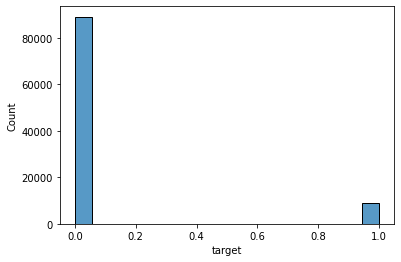

In [18]:
# Target Variable Ocurrency
percent = str(round(sum(df['target'])/len(df['target']), 1)*100) + '%'
print(f'percentage of target == 1 is: {percent}')
sns.histplot(data=df['target'])

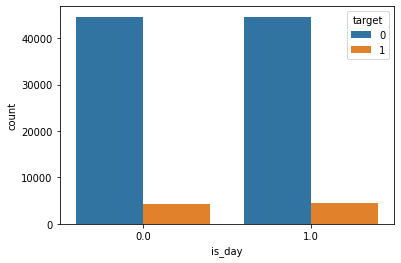

In [19]:
sns.countplot(x=df['is_day'], hue=df['target'])

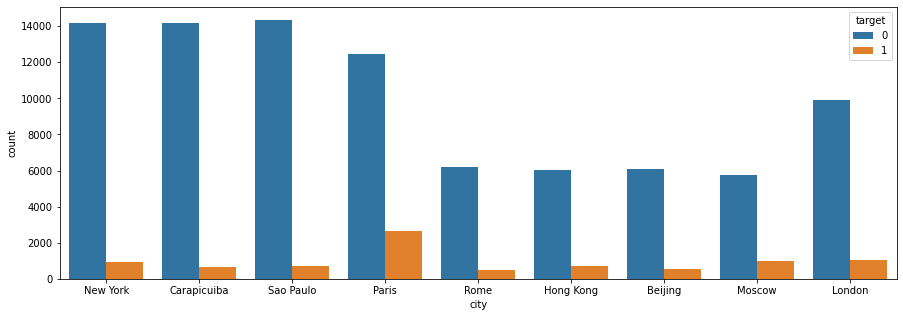

In [20]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x=df['city'], hue=df['target'])

<Figure size 720x360 with 0 Axes>

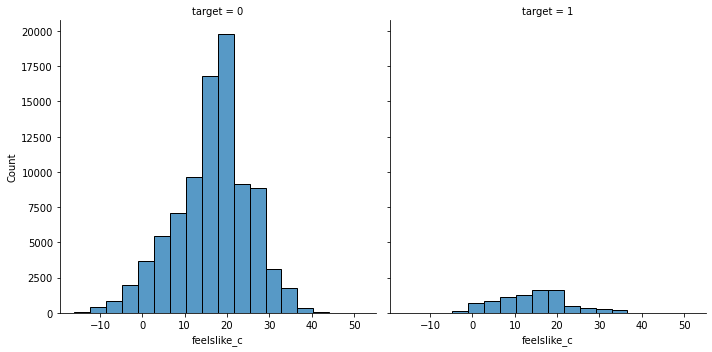

In [21]:
plt.figure(figsize=(10, 5))
ax = sns.displot(x=df['feelslike_c'], bins='sturges', col=df['target'])

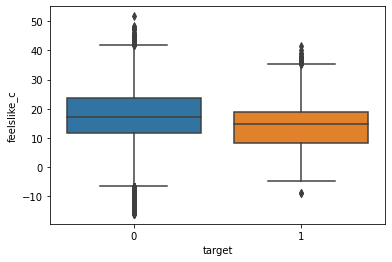

In [22]:
sns.boxplot(x=df['target'], y=df['feelslike_c'])

<Figure size 720x360 with 0 Axes>

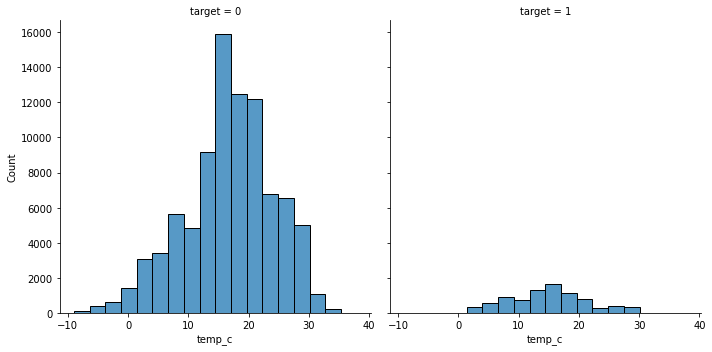

In [23]:
plt.figure(figsize=(10, 5))
ax = sns.displot(x=df['temp_c'], bins='sturges', col=df['target'])

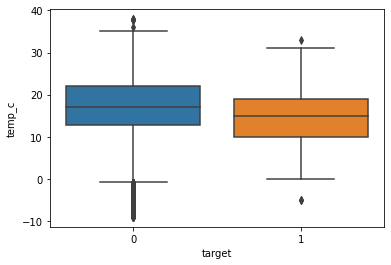

In [24]:
sns.boxplot(x=df['target'], y=df['temp_c'])

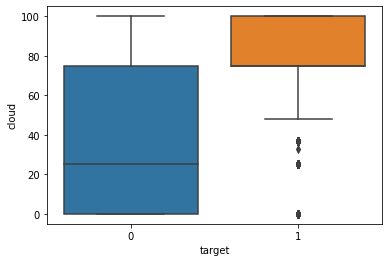

In [25]:
sns.boxplot(x=df['target'], y=df['cloud'])

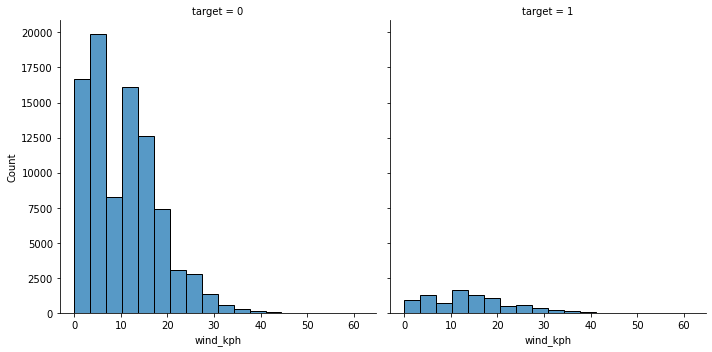

In [26]:
sns.displot(x=df['wind_kph'], col=df['target'], bins='sturges')

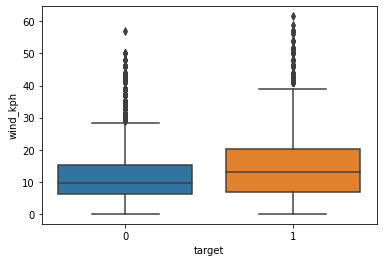

In [27]:
sns.boxplot(x=df['target'], y=df['wind_kph'])

In [28]:
df.describe()

,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,target
count,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000
mean,16.636618,61.946013,0.501006,6.785977,10.914232,163.831707,1016.820018,30.169358,0.262013,0.010129,71.013937,38.607616,16.436316,61.581570,10.187202,5.959079,2.991223,10.091323,16.239476,0.089363
std,7.310923,13.159785,0.500002,4.931780,7.947392,104.532379,7.638399,0.328624,1.668816,0.065744,18.277906,38.880118,8.841164,15.913406,2.788276,1.640698,2.312982,5.718242,9.202578,0.285268
min,-9.000000,15.800000,0.000000,0.000000,0.000000,0.000000,967.000000,28.560000,0.000000,0.000000,8.000000,0.000000,-16.100000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,12.000000,53.600000,0.000000,3.800000,6.100000,80.000000,1013.000000,29.970000,0.000000,0.000000,60.000000,0.000000,11.100000,51.900000,10.000000,6.000000,1.000000,6.000000,9.700000,0.000000
50%,17.000000,62.600000,1.000000,6.900000,11.200000,150.000000,1018.000000,30.120000,0.000000,0.000000,75.000000,25.000000,17.000000,62.600000,10.000000,6.000000,1.000000,9.200000,14.800000,0.000000
75%,21.700000,71.100000,1.000000,9.400000,15.100000,250.000000,1022.000000,30.400000,0.000000,0.000000,87.000000,75.000000,21.700000,71.100000,10.000000,6.000000,5.000000,13.000000,20.900000,0.000000
max,37.900000,100.200000,1.000000,38.300000,61.600000,360.000000,1044.000000,31.000000,113.800000,4.480000,100.000000,100.000000,51.700000,125.100000,16.000000,9.000000,9.000000,57.700000,92.900000,1.000000


### **4. Modelling DataSet for MachineLearning Algorithm**

In [29]:
# Our goal is to predict weather is going to rain or not based on the last register
# Now we're going to split the data
train_df = df[['last_updated', 'city', 'temp_c', 'is_day', 'condition', 'wind_kph', 'wind_degree'
          , 'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv'
          , 'gust_kph', 'target']]

In [30]:
train_df = train_df.sort_values(by=['city', 'last_updated']).reset_index().drop(columns='index')

In [31]:
# Calculate the difference between the actual and previous register
def date_diff_calc(df_column):
  i = 1
  date_diff_list = list()
  for cell in df_column:
    if i < len(df_column):
      date_diff_min = (df_column[i] - cell).total_seconds()/60
      date_diff_list.append(date_diff_min)
      i += 1
  return date_diff_list

In [32]:
train_df['date_diff'] = pd.DataFrame(date_diff_calc(train_df['last_updated']))

In [33]:
# create a column that tells us weather is raining in the next hour
def rain_next1(df_column):
  i = 4
  rain_next1 = list()
  for cell in df_column:
    if i < len(df_column):
      rain_next1.append(df_column[i])
      i += 1
  return rain_next1

In [34]:
train_df['target_1'] = pd.DataFrame(rain_next1(train_df['target']))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


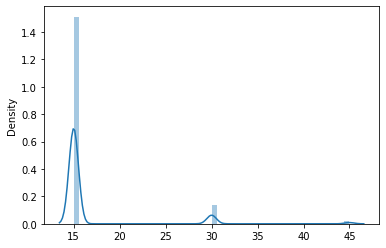

In [35]:
sns.distplot(x=train_df['date_diff'].loc[train_df['date_diff'] > -50].loc[train_df['date_diff'] < 50])

In [36]:
train_df = train_df.drop(columns=['date_diff', 'last_updated'])

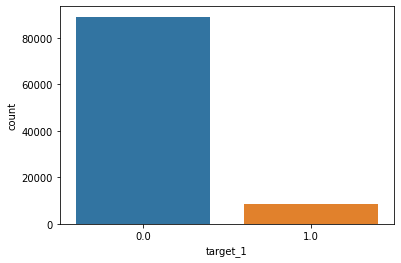

In [37]:
sns.countplot(x=train_df['target_1'])

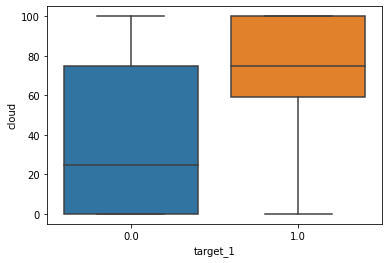

In [38]:
sns.boxplot(y=train_df['cloud'], x=train_df['target_1'])

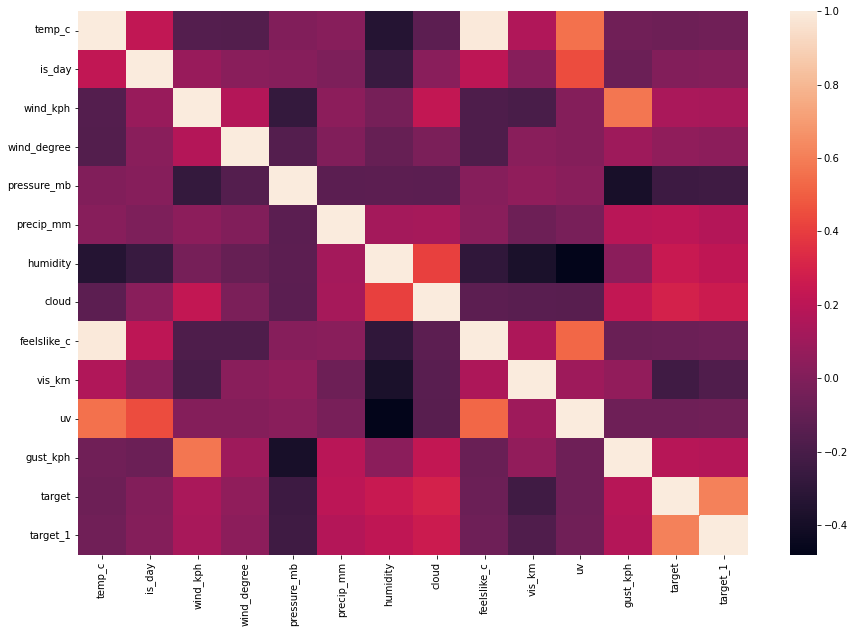

In [63]:
plt.figure(figsize=(15,10))
sns.heatmap(train_df.corr())

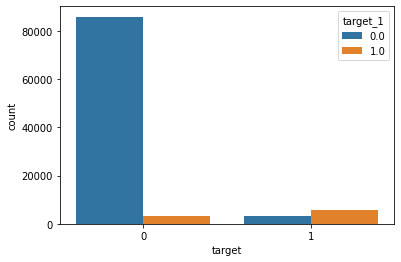

In [58]:
sns.countplot(x=train_df['target'], hue=train_df['target_1'])

In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97871 entries, 0 to 97870
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         97871 non-null  object 
 1   temp_c       97871 non-null  float64
 2   is_day       97871 non-null  float64
 3   condition    97871 non-null  object 
 4   wind_kph     97871 non-null  float64
 5   wind_degree  97871 non-null  float64
 6   pressure_mb  97871 non-null  float64
 7   precip_mm    97871 non-null  float64
 8   humidity     97871 non-null  float64
 9   cloud        97871 non-null  float64
 10  feelslike_c  97871 non-null  float64
 11  vis_km       97871 non-null  float64
 12  uv           97871 non-null  float64
 13  gust_kph     97871 non-null  float64
 14  target       97871 non-null  int64  
 15  target_1     97867 non-null  float64
dtypes: float64(13), int64(1), object(2)
memory usage: 11.9+ MB


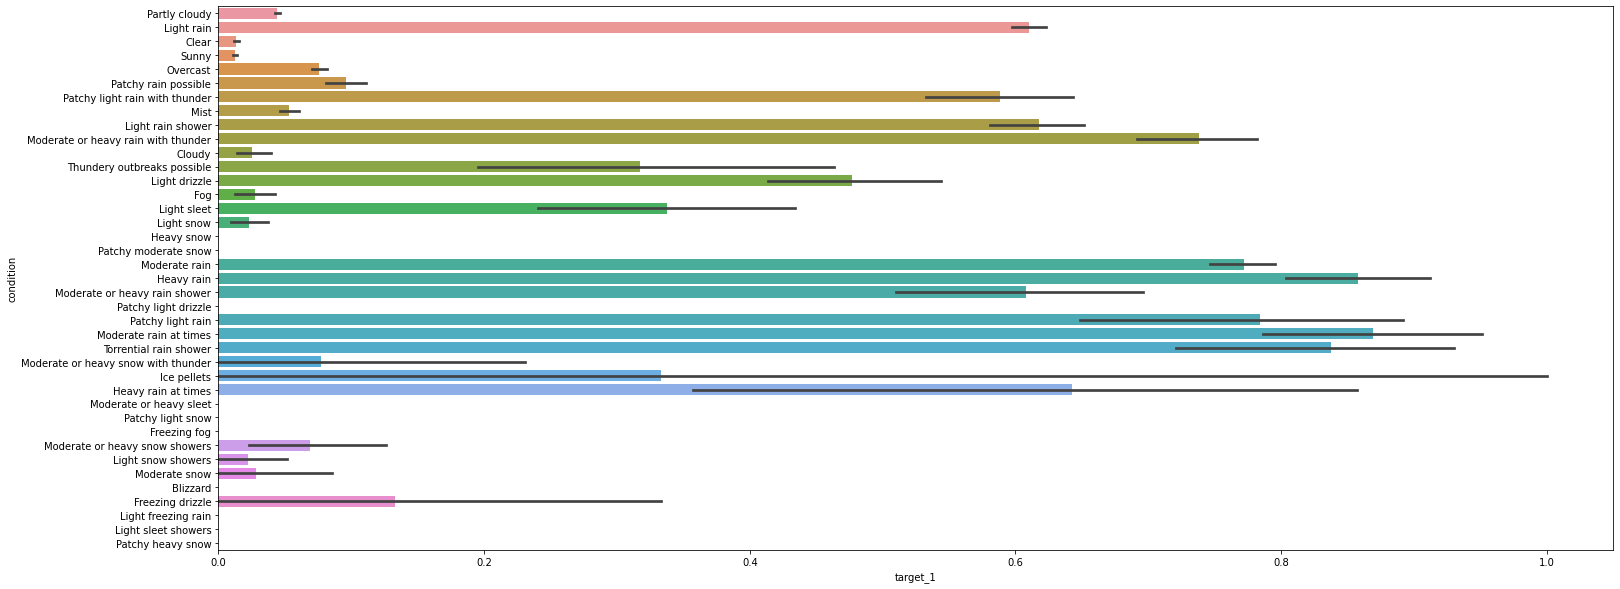

In [64]:
plt.figure(figsize=(25, 10))
sns.barplot(y=train_df['condition'], x=train_df['target_1'], orient='horizontal')

In [65]:
# Transform categorical variables in columns and generate X array
x = pd.get_dummies(train_df.drop(columns='target_1'), columns=['condition', 'city'])
x.head()

,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,target,condition_Blizzard,condition_Clear,condition_Cloudy,condition_Fog,condition_Freezing drizzle,condition_Freezing fog,condition_Heavy rain,condition_Heavy rain at times,condition_Heavy snow,condition_Ice pellets,condition_Light drizzle,condition_Light freezing rain,condition_Light rain,condition_Light rain shower,condition_Light sleet,condition_Light sleet showers,condition_Light snow,condition_Light snow showers,condition_Mist,condition_Moderate or heavy rain shower,condition_Moderate or heavy rain with thunder,condition_Moderate or heavy sleet,condition_Moderate or heavy snow showers,condition_Moderate or heavy snow with thunder,condition_Moderate rain,condition_Moderate rain at times,condition_Moderate snow,condition_Overcast,condition_Partly cloudy,condition_Patchy heavy snow,condition_Patchy light drizzle,condition_Patchy light rain,condition_Patchy light rain with thunder,condition_Patchy light snow,condition_Patchy moderate snow,condition_Patchy rain possible,condition_Sunny,condition_Thundery outbreaks possible,condition_Torrential rain shower,city_Beijing,city_Carapicuiba,city_Hong Kong,city_London,city_Moscow,city_New York,city_Paris,city_Rome,city_Sao Paulo
0,27.0,1.0,6.8,140.0,1013.0,1.5,70.0,25.0,31.6,10.0,5.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,18.6,1.0,6.5,2.0,1011.0,0.0,62.0,9.0,18.6,10.0,5.0,11.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,21.0,1.0,19.1,280.0,1015.0,0.0,73.0,0.0,21.0,10.0,6.0,8.6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,21.0,1.0,19.1,280.0,1015.0,0.0,73.0,0.0,21.0,10.0,6.0,8.6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,21.0,0.0,0.0,221.0,1012.0,0.3,83.0,0.0,21.0,10.0,5.0,9.7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [66]:
# Create Y array and clean it
y = train_df['target_1']
y = y.fillna(0.0)
y = y.astype('int')
y.unique()

array([0, 1])

In [93]:
# Split the data between Train and Test
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [94]:
if len(x) == len(y):
  pass
else:
  raise Exception ("The data was splitted wrong")

In [95]:
print(f'train: {x_train.shape}\ntest: {x_test.shape}')

train: (73403, 61)
test: (24468, 61)


### **5. Applying Machine Learning Model**

In [96]:
lr = LogisticRegression(random_state=0, max_iter=10000).fit(x_train, y_train)

In [97]:
lr.score(x_test, y_test)

0.93563021088769

In [98]:
#x_test['prediction'] = lr.predict(x_test)

In [99]:
#prob_list = []
#a = lr.predict_proba(x_test.drop(columns='prediction'))
#for i in a:
 # prob_list.append(i[0])

In [100]:
#x_test['prob'] = prob_list
#x_test

In [101]:
#sns.boxplot(x=x_test['prediction'], y=x_test['prob'])

In [102]:
#plt.figure(figsize=(10,7))
#sns.histplot(hue=x_test['prediction'], x=x_test['prob'], bins='sturges')

In [106]:
lr_pred = lr.predict(x_test)
print(classification_report(y_test, lr_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22219
           1       0.68      0.55      0.61      2249

    accuracy                           0.94     24468
   macro avg       0.82      0.76      0.79     24468
weighted avg       0.93      0.94      0.93     24468



In [118]:
from sklearn.neighbors import KNeighborsClassifier
for k in (range(3, 7)):
  neigh = KNeighborsClassifier(n_neighbors=k, algorithm = 'auto', weights='distance', p=1)
  neigh.fit(x_train, y_train)
  neigh_pred = neigh.predict(x_test)
  print(f'k: {k}')
  print(classification_report(y_test, neigh_pred, labels=[0,1]))

k: 3
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     22219
           1       0.78      0.72      0.75      2249

    accuracy                           0.96     24468
   macro avg       0.88      0.85      0.86     24468
weighted avg       0.95      0.96      0.95     24468

k: 4
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     22219
           1       0.79      0.71      0.75      2249

    accuracy                           0.96     24468
   macro avg       0.88      0.85      0.86     24468
weighted avg       0.95      0.96      0.95     24468

k: 5
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     22219
           1       0.79      0.71      0.75      2249

    accuracy                           0.96     24468
   macro avg       0.88      0.84      0.86     24468
weighted avg       0.95      0.96      0.95     24468

k: 6

In [79]:
filename = 'model_v1'
pickle.dump(lr, open(filename, 'wb'))
#loaded_model = pickle.load(open(filename, 'rb'))

In [80]:
df_empty = x_test[0:0]
df_empty = df_empty.drop(columns=['prediction', 'prob'])
pickle.dump(df_empty, open('df_mask', 'wb'))